In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

In [14]:
df = pd.read_csv("../data/renewable_power.csv")

df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time')
df.set_index('Time', inplace=True)

series = df['Energy delta[Wh]']
series_hourly = series.resample('H').sum()

print(df)

                     Energy delta[Wh]   GHI  temp  pressure  humidity  \
Time                                                                    
2017-01-01 00:00:00                 0   0.0   1.6      1021       100   
2017-01-01 00:15:00                 0   0.0   1.6      1021       100   
2017-01-01 00:30:00                 0   0.0   1.6      1021       100   
2017-01-01 00:45:00                 0   0.0   1.6      1021       100   
2017-01-01 01:00:00                 0   0.0   1.7      1020       100   
...                               ...   ...   ...       ...       ...   
2022-08-31 16:45:00               118  23.7  18.6      1023        57   
2022-08-31 17:00:00                82  15.6  18.5      1023        61   
2022-08-31 17:15:00                51   8.0  18.5      1023        61   
2022-08-31 17:30:00                24   2.1  18.5      1023        61   
2022-08-31 17:45:00                 0   0.0  18.5      1023        61   

                     wind_speed  rain_1h  snow_1h 

In [15]:
hours_per_day = 24
days = 60

recent_series = series_hourly[-hours_per_day * days:]

In [16]:
test_hours = 24 * 7

train = recent_series[:-test_hours]
test = recent_series[-test_hours:]

In [17]:
baseline_pred = test.shift(1)
baseline_pred.iloc[0] = train.iloc[-1]

mae_baseline = mean_absolute_error(test, baseline_pred)
rmse_baseline = np.sqrt(mean_squared_error(test, baseline_pred))

print("===== Persistence Model =====")
print("Train Size:", len(train))
print("Test Size:", len(test))
print("MAE:", mae_baseline)
print("RMSE:", rmse_baseline)
print()

===== Persistence Model =====
Train Size: 1272
Test Size: 168
MAE: 1067.1666666666667
RMSE: 1902.2099835266797



In [18]:
print("===== SARIMA Model =====")
print("Training SARIMA (1,0,1)(1,0,1,24)...")

model = SARIMAX(train,
                order=(1,0,1),
                seasonal_order=(1,0,1,24),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

sarima_pred = results.forecast(steps=test_hours)

mae_sarima = mean_absolute_error(test, sarima_pred)
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_pred))

print("Model Fitted.")
print("MAE:", mae_sarima)
print("RMSE:", rmse_sarima)
print()

===== SARIMA Model =====
Training SARIMA (1,0,1)(1,0,1,24)...
Model Fitted.
MAE: 1554.843744344709
RMSE: 2891.693528078562



In [19]:
print("===== Random Forest Model =====")

recent_df = df.resample('H').sum().iloc[-hours_per_day * days:]

recent_df['hour'] = recent_df.index.hour
recent_df['month'] = recent_df.index.month

recent_df['hour_sin'] = np.sin(2*np.pi*recent_df['hour']/24)
recent_df['hour_cos'] = np.cos(2*np.pi*recent_df['hour']/24)

features = ['hour_sin','hour_cos','temp','clouds_all','humidity']

train_df = recent_df[:-test_hours]
test_df = recent_df[-test_hours:]

X_train = train_df[features]
y_train = train_df['Energy delta[Wh]']

X_test = test_df[features]
y_test = test_df['Energy delta[Wh]']


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))

print("Train Size:", len(X_train))
print("Test Size:", len(X_test))
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print()

===== Random Forest Model =====
Train Size: 1272
Test Size: 168
MAE: 1168.3934503968253
RMSE: 2213.691891798614



In [20]:
print("===== MLP Neural Network =====")

lstm_series = recent_series.copy()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(lstm_series.values.reshape(-1,1))

sequence_length = 24

X = []
y = []

for i in range(sequence_length, len(scaled)):
    X.append(scaled[i-sequence_length:i])
    y.append(scaled[i])

X = np.array(X)
y = np.array(y)

X_train = X[:-test_hours]
X_test = X[-test_hours:]

y_train = y[:-test_hours]
y_test = y[-test_hours:]

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

mlp = MLPRegressor(hidden_layer_sizes=(64,32),
                   activation='relu',
                   max_iter=300,
                   random_state=42)

mlp.fit(X_train_flat, y_train.ravel())

mlp_pred = mlp.predict(X_test_flat)

mlp_pred_actual = scaler.inverse_transform(mlp_pred.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test)

mae_mlp = mean_absolute_error(y_test_actual, mlp_pred_actual)
rmse_mlp = np.sqrt(mean_squared_error(y_test_actual, mlp_pred_actual))

print("Train Samples:", len(X_train_flat))
print("Test Samples:", len(X_test_flat))
print("MAE:", mae_mlp)
print("RMSE:", rmse_mlp)
print()

===== MLP Neural Network =====
Train Samples: 1248
Test Samples: 168
MAE: 887.1070959804113
RMSE: 1418.736408615407



In [21]:
results_table = pd.DataFrame({
    "Model": [
        "Persistence",
        "SARIMA (1,0,1)(1,0,1,24)",
        "Random Forest",
        "MLP Neural Network"
    ],
    "MAE": [
        mae_baseline,
        mae_sarima,
        mae_rf,
        mae_mlp
    ],
    "RMSE": [
        rmse_baseline,
        rmse_sarima,
        rmse_rf,
        rmse_mlp
    ]
})

results_table.sort_values("MAE").reset_index(drop=True)

,Model,MAE,RMSE
0,MLP Neural Network,887.107096,1418.736409
1,Persistence,1067.166667,1902.209984
2,Random Forest,1168.393450,2213.691892
3,"SARIMA (1,0,1)(1,0,1,24)",1554.843744,2891.693528


<Figure size 1200x600 with 0 Axes>

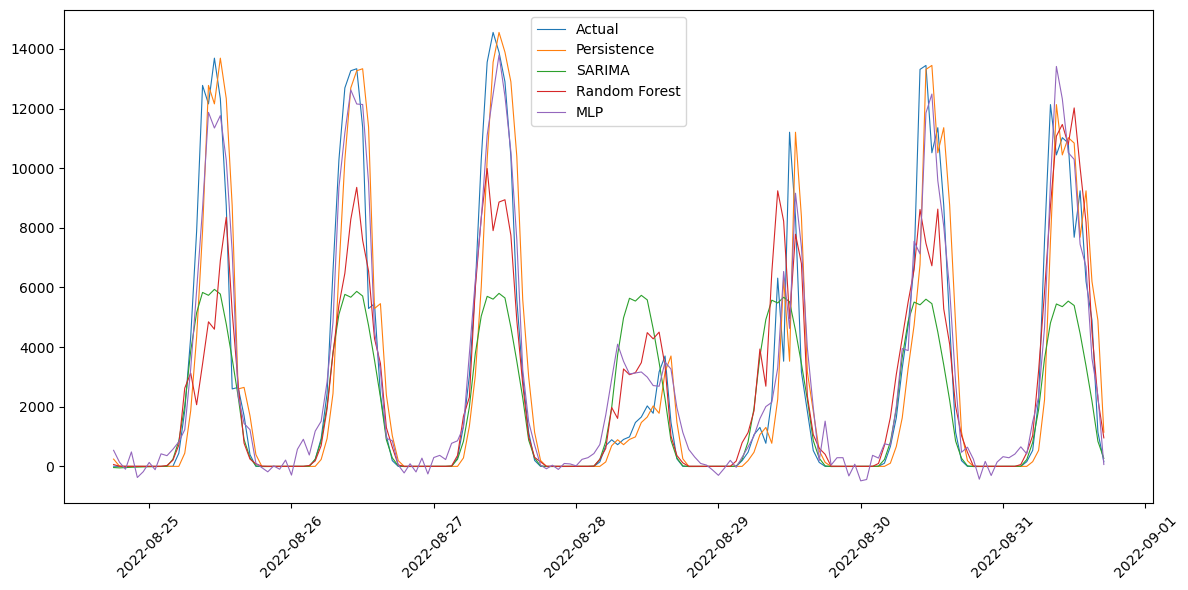

In [ ]:
plt.figure(figsize=(12,6))

plt.figure(figsize=(12,6))

plt.plot(test.index, test.values, label="Actual", linewidth=0.8)
plt.plot(test.index, baseline_pred.values, label="Persistence", linewidth=0.8)
plt.plot(test.index, sarima_pred.values, label="SARIMA", linewidth=0.8)
plt.plot(test.index, rf_pred, label="Random Forest", linewidth=0.8)
plt.plot(test.index, mlp_pred_actual.flatten(), label="MLP", linewidth=0.8)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

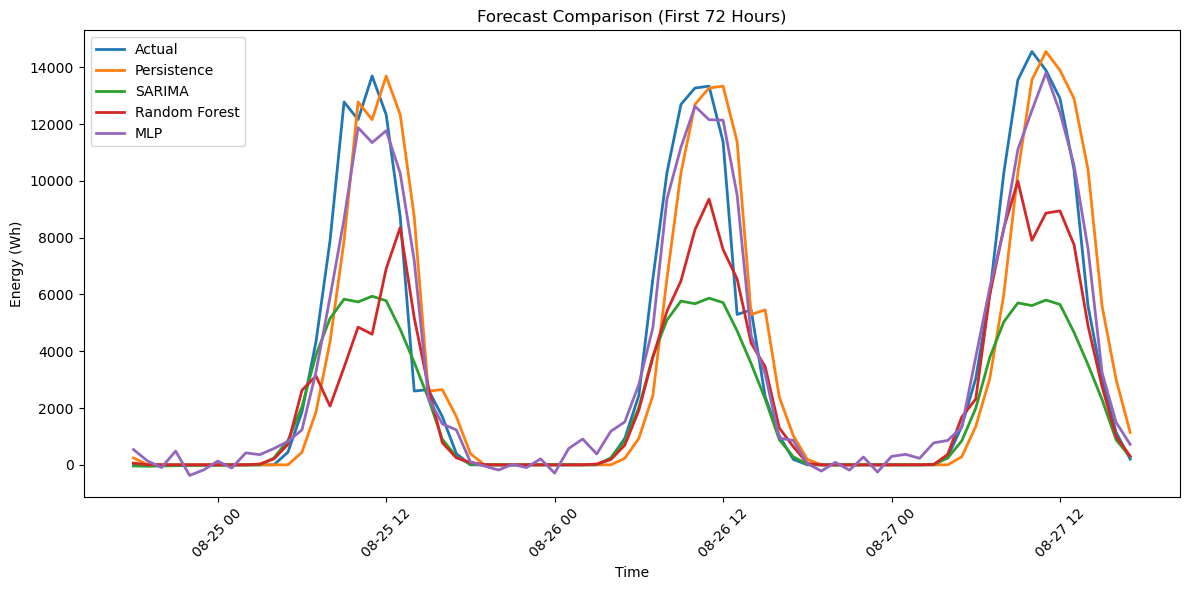

In [ ]:
plt.figure(figsize=(12,6))
zoom_hours = 72

plt.plot(test.index[:zoom_hours], test.values[:zoom_hours], label="Actual", linewidth=2)
plt.plot(test.index[:zoom_hours], baseline_pred.values[:zoom_hours], label="Persistence", linewidth=2)
plt.plot(test.index[:zoom_hours], sarima_pred.values[:zoom_hours], label="SARIMA", linewidth=2)
plt.plot(test.index[:zoom_hours], rf_pred[:zoom_hours], label="Random Forest", linewidth=2)
plt.plot(test.index[:zoom_hours], mlp_pred_actual.flatten()[:zoom_hours], label="MLP", linewidth=2)

plt.title("Forecast Comparison (First 72 Hours)")
plt.xlabel("Time")
plt.ylabel("Energy (Wh)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()